# 1. Liiketoiminnan Ymmärtäminen
#### Tutkimuskysymykset:
##### 1. Mikä on oppituntien läsnäolon vaikutus opiskelijoiden yleisiin arvosanoihin?
##### 2. Ovatko tietyt jaksot, joissa on enemmän poissaoloja, yhteydessä alhaisempiin arvosanoihin? Onko poissaoloja enemmän tietyissä oppitunneissa?
##### 3. Onko tietyillä luokka-asteilla (esim. 9., 10., 11. tai 12. luokka) korkeampi poissaolojen määrä tai alhaisemmat arvosanat?
##### 4. Mitkä tekijät ennustavat heikkoa koulumenestystä (esim. keskiarvo tietyn kynnyksen alapuolella)?


# 2: Datan Ymmärtäminen

In [198]:
import pandas as pd
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# datasetti
file_path = 'archive/2023_GradesVsPeriodAttendance_01.csv'
data = pd.read_csv(file_path)

# ensimmäiset rivit ja yhteenveto datasetistä
data_info = data.info()
data_head = data.head()

print(data_info)
print(data_head)

# datasetin ainutlaatuiset luokka-asteet
print("Ainutlaatuiset luokka-asteet datasetissä:", data['grade'].unique())

# kirjaimelliset arvosanat numeerisiksi analyysiä varten
grade_mapping = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0}
for col in ['bellPeriod1_markbook_mark', 'bellPeriod2_markbook_mark', 'bellPeriod3_markbook_mark',
            'bellPeriod4_markbook_mark', 'bellPeriod5_markbook_mark', 'bellPeriod6_markbook_mark']:
    data[col] = data[col].map(grade_mapping)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21305 entries, 0 to 21304
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   school_name                21305 non-null  object
 1   student_id                 21305 non-null  object
 2   grade                      21305 non-null  int64 
 3   term_code                  21305 non-null  object
 4   bellPeriod1_absences       21305 non-null  int64 
 5   bellPeriod2_absences       21305 non-null  int64 
 6   bellPeriod3_absences       21305 non-null  int64 
 7   bellPeriod4_absences       21305 non-null  int64 
 8   bellPeriod5_absences       21305 non-null  int64 
 9   bellPeriod6_absences       21305 non-null  int64 
 10  total_absences             21305 non-null  int64 
 11  bellPeriod1_markbook_mark  20222 non-null  object
 12  bellPeriod2_markbook_mark  20202 non-null  object
 13  bellPeriod3_markbook_mark  20652 non-null  object
 14  bellPe

# 3: Datan Valmistelu


In [199]:
# Laskuri keskimääräiselle arvosanalle
data['average_grade'] = data[['bellPeriod1_markbook_mark', 'bellPeriod2_markbook_mark', 
                              'bellPeriod3_markbook_mark', 'bellPeriod4_markbook_mark', 
                              'bellPeriod5_markbook_mark', 'bellPeriod6_markbook_mark']].mean(axis=1)

# Pudotus riville, joissa 'average_grade' puuttuu
data_cleaned = data.dropna(subset=['average_grade'])

# Luodaan uusi 'pass_fail' sarake ilman SettingWithCopyWarning-varoitusta
data_cleaned = data_cleaned.assign(pass_fail=(data_cleaned['average_grade'] >= 2).astype(int))

# Varmistetaan, että 'grade'-sarake on kategorinen, varmistaen ensin arvojen tyypin
# Muutetaan ensin arvosanat numeerisiksi, jos tarpeen
data_cleaned['grade'] = pd.to_numeric(data_cleaned['grade'], errors='coerce')

# Sitten muutetaan kategoriseksi
data_cleaned['grade'] = data_cleaned['grade'].astype('category')

# Lasketaan korrelaatio poissaolojen ja arvosanojen välillä
attendance_columns = ['bellPeriod1_absences', 'bellPeriod2_absences', 'bellPeriod3_absences',
                      'bellPeriod4_absences', 'bellPeriod5_absences', 'bellPeriod6_absences', 
                      'total_absences', 'average_grade']

###  Kysymykseen 3: Poissaolojen ja arvosanojen vertailu koulujen välillä valmistelu

grouped_data = data_cleaned.groupby('grade', observed=False).agg({
    'total_absences': 'mean',
    'bellPeriod1_markbook_mark': 'mean',
    'bellPeriod2_markbook_mark': 'mean',
    'bellPeriod3_markbook_mark': 'mean',
    'bellPeriod4_markbook_mark': 'mean',
    'bellPeriod5_markbook_mark': 'mean',
    'bellPeriod6_markbook_mark': 'mean'
}).reset_index()

# Lisää uusi sarake, joka sisältää keskimääräisen arvosanan kaikilta jaksoilta kullekin luokka-asteelle
grouped_data['average_mark'] = grouped_data[
    ['bellPeriod1_markbook_mark', 'bellPeriod2_markbook_mark', 
     'bellPeriod3_markbook_mark', 'bellPeriod4_markbook_mark', 
     'bellPeriod5_markbook_mark', 'bellPeriod6_markbook_mark']].mean(axis=1)

attendance_grade_corr = data_cleaned[attendance_columns].corr()

# Tulosta korrelaatiomatriisi
print("Korrelaatio poissaolojen ja arvosanojen välillä:\n", attendance_grade_corr)


Korrelaatio poissaolojen ja arvosanojen välillä:
                       bellPeriod1_absences  bellPeriod2_absences  \
bellPeriod1_absences              1.000000              0.694444   
bellPeriod2_absences              0.694444              1.000000   
bellPeriod3_absences              0.642589              0.818407   
bellPeriod4_absences              0.621797              0.774154   
bellPeriod5_absences              0.502939              0.641567   
bellPeriod6_absences              0.449898              0.534469   
total_absences                    0.823831              0.887159   
average_grade                    -0.345172             -0.348782   

                      bellPeriod3_absences  bellPeriod4_absences  \
bellPeriod1_absences              0.642589              0.621797   
bellPeriod2_absences              0.818407              0.774154   
bellPeriod3_absences              1.000000              0.795445   
bellPeriod4_absences              0.795445              1.000000 

# 4: Mallinnus

In [200]:
# Tutkimuskysymys 1: Läsnäolon vaikutus yleisiin arvosanoihin (Random Forest Regressor)
features = data_cleaned[['bellPeriod1_absences', 'bellPeriod2_absences', 'bellPeriod3_absences',
                         'bellPeriod4_absences', 'bellPeriod5_absences', 'bellPeriod6_absences', 'total_absences']]
target = data_cleaned['average_grade']

# Jaetaan datasetti koulutus- ja testijoukkoihin
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Koulutetaan Random Forest Regressor -malli
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Tutkimuskysymys 2: Poissaolojaksot ja niiden vaikutus arvosanoihin (Decision Tree Classifier)
decision_tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
decision_tree_model.fit(X_train, data_cleaned.loc[X_train.index, 'pass_fail'])

# Tutkimuskysymys 4: Ennusta heikkoa koulumenestystä (Logistic Regression)
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, data_cleaned.loc[X_train.index, 'pass_fail'])

LogisticRegression(random_state=42)

# 5: Mallin Arviointi
### Kysymys 1: Läsnäolon vaikutus arvosanoihin

Keskineliövirhe (MSE) läsnäolon ja arvosanojen välillä: 0.2715535732137406
R² tulos läsnäolon ja arvosanojen välillä: 0.72551717631622
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      6218
           1       0.90      0.96      0.93     15070

    accuracy                           0.89     21288
   macro avg       0.89      0.84      0.86     21288
weighted avg       0.89      0.89      0.89     21288



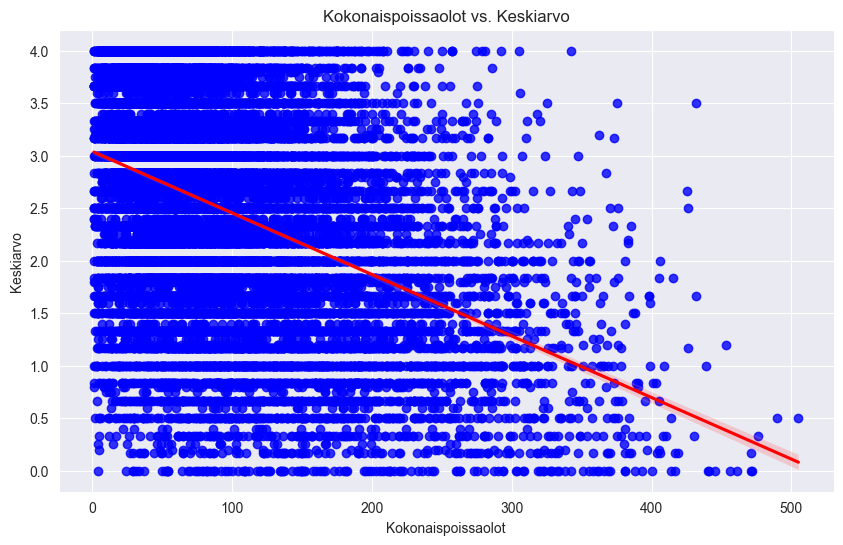

In [201]:
from sklearn.metrics import mean_squared_error, r2_score, classification_report

# Ominaisuudet ja kohde
X = data_cleaned[attendance_columns[:-1]]  # Poistetaan 'average_grade' ominaisuuksista
y = data_cleaned['average_grade']

# Ennustukset Random Forest Regressorilla
y_pred_rf = rf_model.predict(X)

# Lasketaan virhemittarit
mse_rf = mean_squared_error(y, y_pred_rf)  # Käytetään y:ta ennustettuna arvona
r2_rf = r2_score(y, y_pred_rf)

# Tulostetaan raportti
print(f'Keskineliövirhe (MSE) läsnäolon ja arvosanojen välillä: {mse_rf}')
print(f'R² tulos läsnäolon ja arvosanojen välillä: {r2_rf}')

# Muutetaan jatkuvat arvosanat binäärisiksi (läpäisy: arvosanat >= 2)
y_pred_class = (y_pred_rf >= 2).astype(int)
y_class = (y >= 2).astype(int)

# Luodaan luokitteluraportti
print(classification_report(y_class, y_pred_class))

# Piirretään hajontakuvio ja regressioviiva kokonaispoissaolojen ja keskiarvojen välille
plt.figure(figsize=(10, 6))
sns.regplot(x=data_cleaned['total_absences'], y=data_cleaned['average_grade'], 
            scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('Kokonaispoissaolot vs. Keskiarvo')
plt.xlabel('Kokonaispoissaolot')
plt.ylabel('Keskiarvo')
plt.show()

##### Keskineliövirhe (MSE):
- Arvo: 0.2716
- Keskineliövirhe (MSE) mittaa keskimääräistä neliöpoikkeamaa ennustettujen ja todellisten arvosanojen välillä. Alhainen arvo (esim. 0.2716) tarkoittaa, että malli ennustaa arvosanoja melko tarkasti. Tämä viittaa siihen, että läsnäololla on myönteinen vaikutus opiskelijoiden arvosanoihin.
##### R²-tulos:
- Arvo: 0.7255
- R² kertoo kuinka hyvin malli selittää arvosanojen vaihtelua. Arvo 0.7255 tarkoittaa, että noin 72.55 % opiskelijoiden arvosanojen vaihtelusta voidaan selittää läsnäololla. Tämä viittaa siihen, että läsnäololla on merkittävä vaikutus opiskelijoiden suoriutumiseen.

### Kysymys 2: Tiettyjen jaksojen vaikutus arvosanoihin ja poissaoloihin

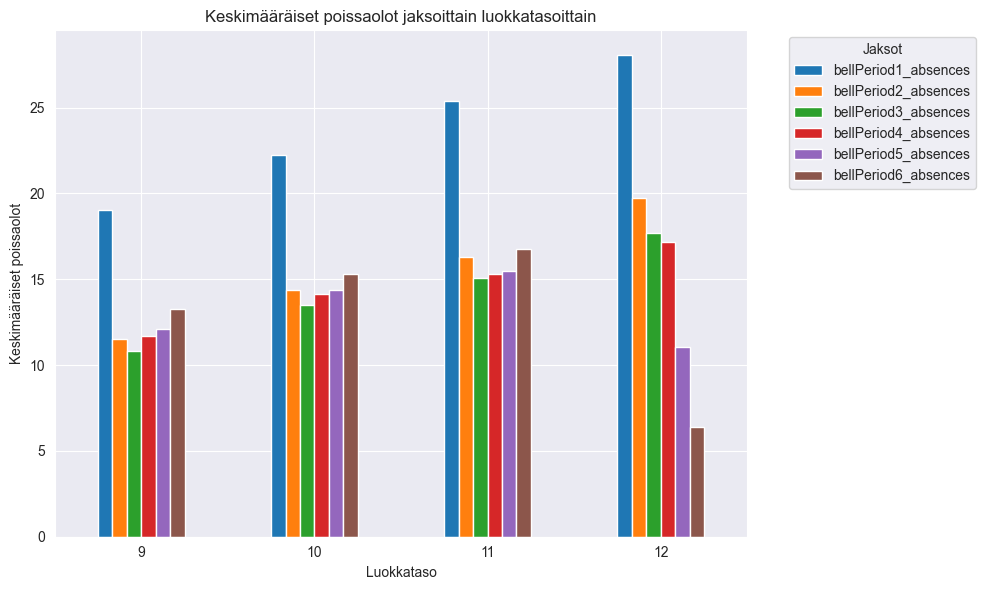

In [202]:
# Keskimääräiset poissaolot jaksoittain luokkatasoittain
average_absences_by_grade = data.groupby('grade')[
    ['bellPeriod1_absences', 'bellPeriod2_absences', 'bellPeriod3_absences',
     'bellPeriod4_absences', 'bellPeriod5_absences', 'bellPeriod6_absences']
].mean()

# Näytä keskimääräiset poissaolot jaksoittain
average_absences_by_grade

# Piirretään pylväsdiagrammi
average_absences_by_grade.plot(kind='bar', figsize=(10,6))
plt.title('Keskimääräiset poissaolot jaksoittain luokkatasoittain')
plt.ylabel('Keskimääräiset poissaolot')
plt.xlabel('Luokkataso')
plt.xticks(rotation=0)
plt.legend(title='Jaksot', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

##### Huomasimme selvät erot poissaolojen määrässä eri jaksojen ja luokkatasojen välillä. Ensimmäinen oppitunti on kaikilla luokkatasoilla alttiimpi poissaoloille verrattuna muihin oppitunteihin. Oppilaiden vanhetessa aamun ensimmäisten oppituntien poissaolot lisääntyvät. Toisaalta kuudennen oppitunnin poissaolot vähenevät, erityisesti vanhempien oppilaiden keskuudessa, mikä saattaa viitata mahdollisiin aikataulumuutoksiin tai lisääntyneeseen oppilaiden sitoutumiseen päivän myöhemmillä oppitunneilla.
##### Tämä tieto voisi auttaa kouluja keskittymään aamun ensimmäisten oppituntien parantamiseen poissaolojen vähentämiseksi, erityisesti ylemmillä luokkatasoilla.

#### Puu rakenne

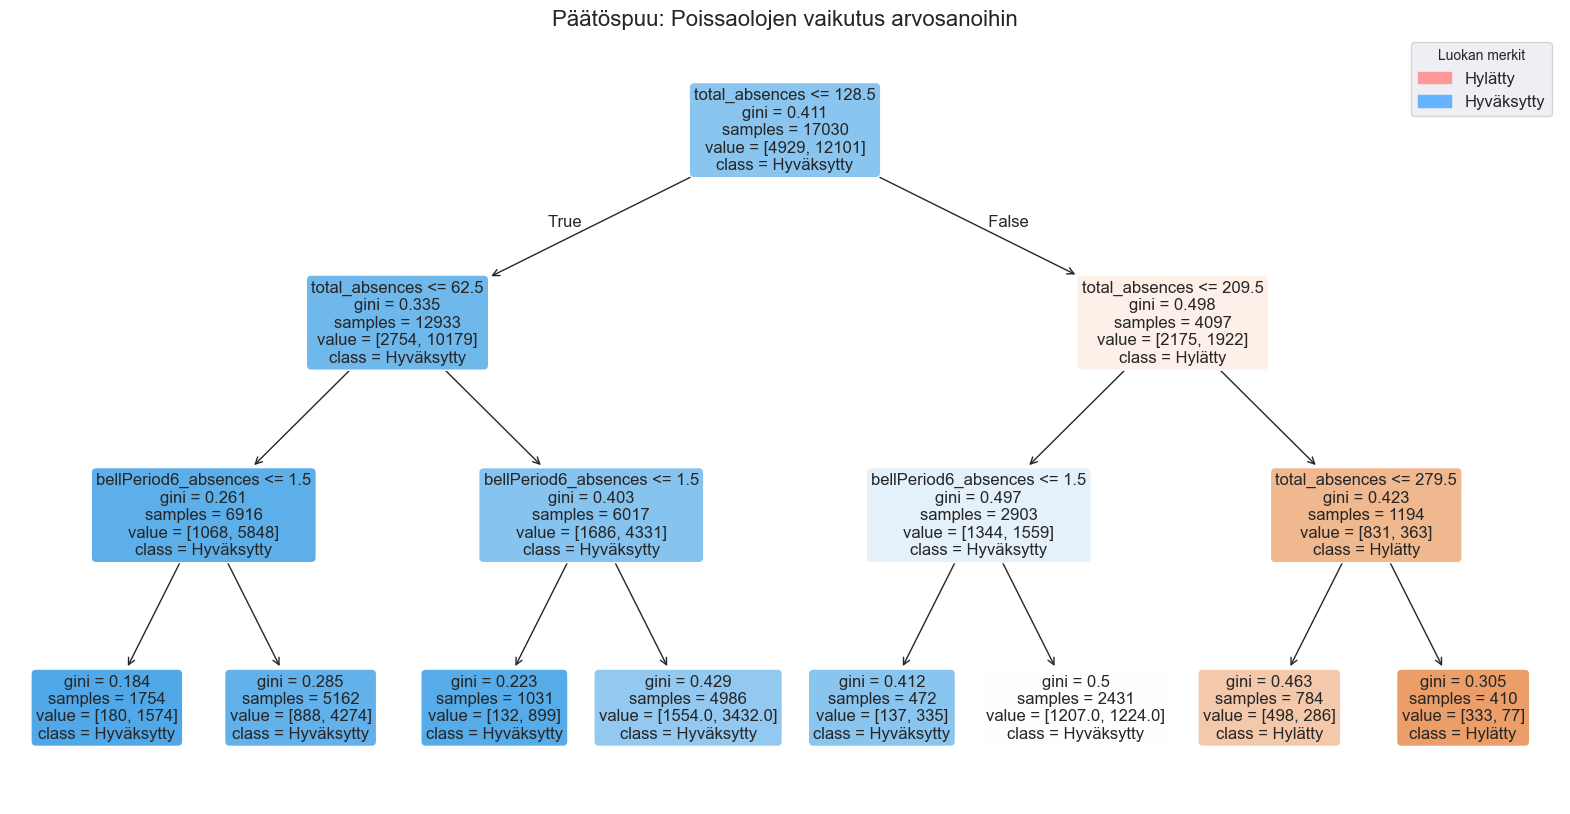

Tarkkuus hylätty/hyväksytty ennustamisessa päätöspuulla: 0.73

Luokitteluraportti:

              precision    recall  f1-score   support

     Hylätty       0.71      0.18      0.28      1289
  Hyväksytty       0.73      0.97      0.83      2969

    accuracy                           0.73      4258
   macro avg       0.72      0.57      0.56      4258
weighted avg       0.72      0.73      0.67      4258



In [203]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, classification_report

# kuvan koko
plt.figure(figsize=(20, 10))

# päätöspuu
plot_tree(
    decision_tree_model,
    feature_names=features.columns,
    filled=True,
    class_names=['Hylätty', 'Hyväksytty'],
    rounded=True,
    fontsize=12
)

# otsikko
plt.title('Päätöspuu: Poissaolojen vaikutus arvosanoihin', fontsize=16)


# legenda luokille
import matplotlib.patches as mpatches

# Määrittellää legenda kaikille luokille
legend_labels = ['Hylätty', 'Hyväksytty']
legend_colors = ['#FF9999', '#66B3FF']  # Vastaavat värit luokille
patches = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
plt.legend(handles=patches, title="Luokan merkit", fontsize=12)

plt.show()

# Arvioitu päätöspuu
y_pred_dt = decision_tree_model.predict(X_test)
accuracy_dt = accuracy_score(data_cleaned.loc[X_test.index, 'pass_fail'], y_pred_dt)
print(f'Tarkkuus hylätty/hyväksytty ennustamisessa päätöspuulla: {accuracy_dt:.2f}')

# luokitteluraportti
print("\nLuokitteluraportti:\n")
print(classification_report(data_cleaned.loc[X_test.index, 'pass_fail'], y_pred_dt, target_names=['Hylätty', 'Hyväksytty']))


##### Päätöspuun keskeinen päätöspiste on se, ylittävätkö kokonaispoissaolot 128,5 jaksoa. Tämä on tärkein tekijä ennustettaessa, tuleeko opiskelija hyväksytyksi vai hylätyksi.
- Opiskelijat, joilla on alle 128,5 poissaoloa, ovat todennäköisemmin hyväksyttyjä.
- Opiskelijat, joilla on yli 128,5 poissaoloa, ovat todennäköisemmin hylättyjä.
##### Ensimmäisen jakson poissaolot ovat voimakkaasti yhteydessä hylkäykseen, kun taas kuudennen jakson poissaolot auttavat myös suorituksen ennustamisessa.
##### Väri koodaus:
- Siniset solmut osoittavat, että enemmistö opiskelijoista tässä ryhmässä on ennustettu hyväksytyiksi.
- Oranssit solmut osoittavat, että suurin osa on ennustettu hylätyiksi.
##### Gini-kerroin mittaa, kuinka hyvin solmu erottaa hyväksytyt ja hylätyt opiskelijat. Alhaisempi Gini-indeksi osoittaa "puhtaamman" solmun, jossa on parempi erottelu.
- samples = 17030 tarkoittaa, että tietojoukko sisältää 17 030 opiskelijaa.
- value = [4922, 12101] näyttää, että 4 922 opiskelijaa on ennustettu hylätyiksi ja 12 101 hyväksytyiksi.

### Kysymys 3: Ovatko tietyillä luokka-asteilla korkeampi poissaolojen määrä tai alhaisemmat arvosanat?


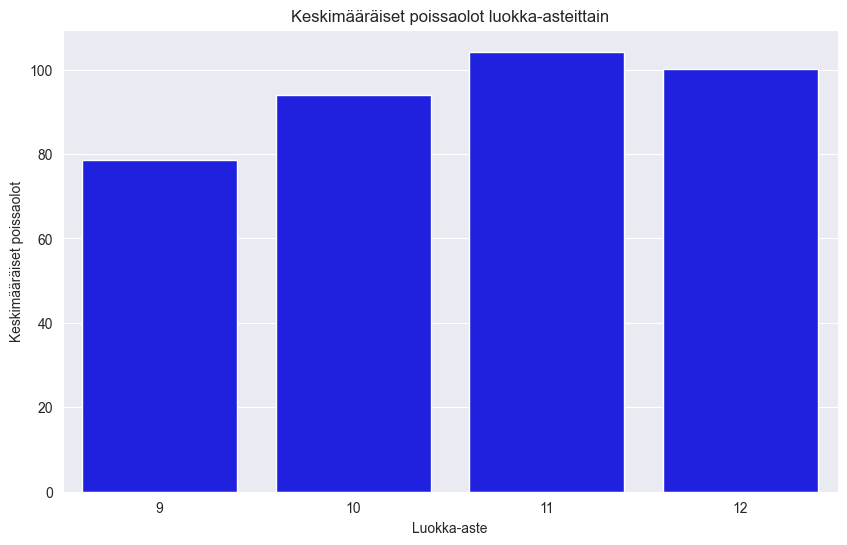

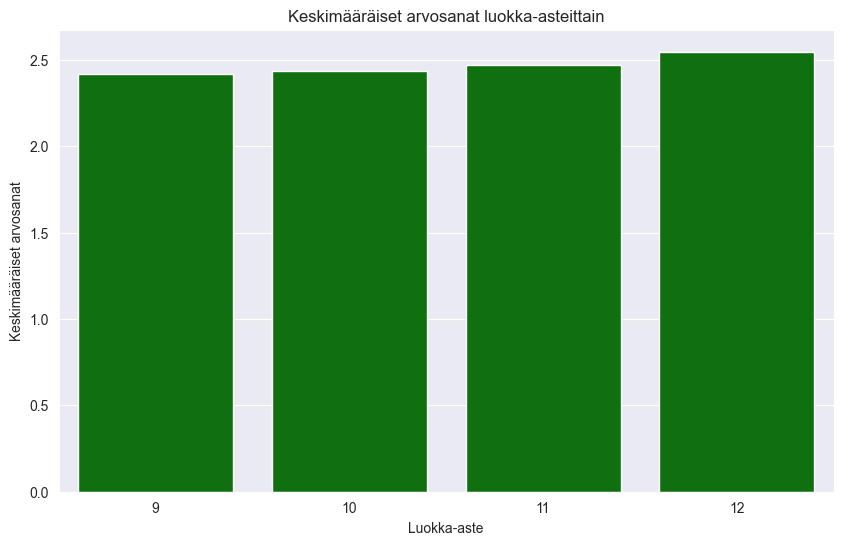

  grade  total_absences  average_mark
0     9       78.466784      2.419157
1    10       94.004964      2.433484
2    11      104.223835      2.468139
3    12      100.129856      2.547743


In [204]:
# Visualisoi poissaolot ja arvosanat luokka-asteittain
plt.figure(figsize=(10, 6))
sns.barplot(x='grade', y='total_absences', data=grouped_data, color='blue')
plt.title('Keskimääräiset poissaolot luokka-asteittain')
plt.xlabel('Luokka-aste')
plt.ylabel('Keskimääräiset poissaolot')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='grade', y='average_mark', data=grouped_data, color='green')
plt.title('Keskimääräiset arvosanat luokka-asteittain')
plt.xlabel('Luokka-aste')
plt.ylabel('Keskimääräiset arvosanat')
plt.show()

# Tulosta taulukko, jossa on luokka-asteet, poissaolot ja arvosanat
print(grouped_data[['grade', 'total_absences', 'average_mark']])


#### Näitte kaavion avulla me huomattii et poissaolojen määrä kasvaa kun mennää korkeammille luokka-asteille, mutta silti arvosanat menee parempaa suuntaa esim luokkalla 11 ja 12.  

#### Tää voi johtuu siitä, että ylemmillä luokilla oppilaat on oppinu parempia opiskelutapoja, vaikka he ovat useammin poissa koulusta 

### Kysymys 4: Mitkä tekijät ennustavat heikkoa koulumenestystä?


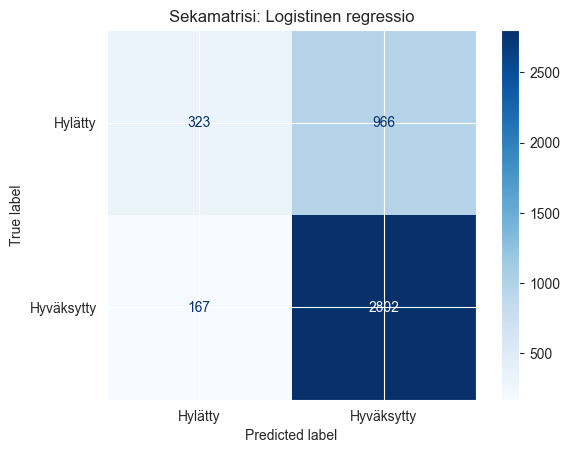

Sekamatrisi numeerisesti:
Todellinen Negatiivinen (TN): 323
Todellinen Positiivinen (TP): 2802
Väärä Positiivinen (FP): 966
Väärä Negatiivinen (FN): 167
Tarkkuus: 0.74
Kattavuus: 0.94
F1-pisteet: 0.83
Luokitteluraportti:

              precision    recall  f1-score   support

           0       0.66      0.25      0.36      1289
           1       0.74      0.94      0.83      2969

    accuracy                           0.73      4258
   macro avg       0.70      0.60      0.60      4258
weighted avg       0.72      0.73      0.69      4258



In [205]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Ennustetaan luokkia logistisella regressiomallilla
y_pred_logistic = logistic_model.predict(X_test)

cm = confusion_matrix(data_cleaned.loc[X_test.index, 'pass_fail'], y_pred_logistic)

# Sekamatrisi
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Hylätty', 'Hyväksytty'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Sekamatrisi: Logistinen regressio')
plt.show()

# Sekamatrisi numeerisesti
tn, fp, fn, tp = cm.ravel()

# Tulostetaan numeeriset tiedot
print("Sekamatrisi numeerisesti:")
print(f'Todellinen Negatiivinen (TN): {tn}')
print(f'Todellinen Positiivinen (TP): {tp}')
print(f'Väärä Positiivinen (FP): {fp}')
print(f'Väärä Negatiivinen (FN): {fn}')
print(f'Tarkkuus: {tp / (tp + fp):.2f}')
print(f'Kattavuus: {tp / (tp + fn):.2f}')
print(f'F1-pisteet: {2 * (tp / (tp + fp)) * (tp / (tp + fn)) / ((tp / (tp + fp)) + (tp / (tp + fn))):.2f}')

# Luokitteluraportti
print("Luokitteluraportti:\n")
print(classification_report(data_cleaned.loc[X_test.index, 'pass_fail'], y_pred_logistic))



##### Logistisen regressiomallin avulla saimme seuraavat havainnot:
- Mallin kokonaiskorkea tarkkuus on 73%, mikä viittaa siihen, että se on kohtuullisen tehokas ennustamaan opiskelijoiden hyväksyntää.

- Kattavuus on 94% positiivisissa tapauksissa (hyväksytyt opiskelijat), mikä tarkoittaa, että malli tunnistaa hyvin hyväksytyt opiskelijat, mutta sen tarkkuus (66%) hylätyissä tapauksissa on alhaisempi.

- F1-pisteet (0.83) osoittavat, että malli saavuttaa hyvän tasapainon tarkkuuden ja kattavuuden välillä hyväksyttyjen opiskelijoiden osalta.

- Kynnysarvo 2.0 on käytetty määrittämään, mitkä opiskelijat on hyväksytty tai hylätty, ja tämä vaikuttaa mallin ennustustarkkuuteen.

# 6: Käyttöönotto
##### Tässä projektissa on käsitelty useita tutkimuskysymyksiä, joissa käytettiin erilaisia koneoppimismalleja. Käytetyt mallit — Random Forest, Decision Trees ja Lineaarinen Regressio — tarjoavat koulutusorganisaatioille tehokkaita työkaluja opiskelijoiden menestyksen ennustamiseen ja analysoimiseen. Mallit voivat auttaa tunnistamaan kriittisiä tekijöitä, jotka vaikuttavat opiskelijoiden suoriutumiseen, ja näin ollen parantaa oppimisympäristöä ja koulutuksen laatua. On kuitenkin tärkeää varmistaa, että mallit rakennetaan ja käytetään eettisesti, ottaen huomioon opiskelijoiden yksilölliset tarpeet ja oikeudet.